<h2>UNIVARIATE ANALYSIS: Variation</h2>

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

sys.path.append(str(Path().resolve().parent))
from src.data_split import get_train_data, get_cv_data, get_test_data, get_train_target, get_test_target, get_cv_target

Text preprocessing completed in 40.15 seconds


Q.1. What is the Variation feature type? <br>
--> Variation is a categorical feature. <br>
Q.2. Total numbers of category in Variation feature and how they are distributed?

In [4]:
train_df = get_train_data()
test_df = get_test_data()
cv_df = get_cv_data()

d_train_variation = train_df['Variation']

print("Total rows:", len(d_train_variation))
print("Data type:", d_train_variation.dtype)
num_unique_variations = d_train_variation.nunique()
print("\nNumber of unique Variation:", num_unique_variations)
print("Missing (NaN) values:", d_train_variation.isna().sum())
print("Empty strings:", (d_train_variation.astype(str).str.strip() == "").sum())

unique_variations = d_train_variation.value_counts()
print("\nTop frequency variations: \n", unique_variations.head(10))

rare_variations = unique_variations[unique_variations == 1]
print("\nVariations appearing only once:", len(rare_variations))

Total rows: 2121
Data type: object

Number of unique Variation: 1926
Missing (NaN) values: 0
Empty strings: 0

Top frequency variations: 
 Variation
Truncating Mutations    59
Deletion                47
Amplification           46
Fusions                 21
Overexpression           3
E17K                     3
T58I                     3
Q61H                     3
M1R                      2
G67R                     2
Name: count, dtype: int64

Variations appearing only once: 1900


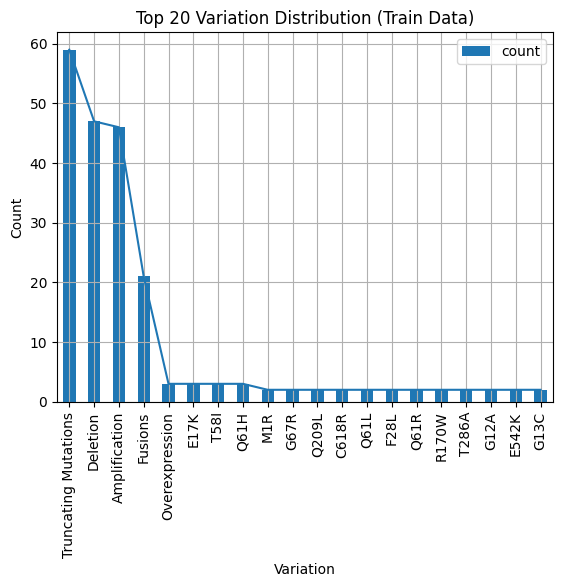

In [6]:
top_n = 20
top_genes = unique_variations.head(top_n)
top_genes.plot(kind="bar")
plt.plot(top_genes)
plt.xlabel("Variation")
plt.ylabel("Count")
plt.title(f"Top {top_n} Variation Distribution (Train Data)")
plt.grid()
plt.legend()
plt.show()

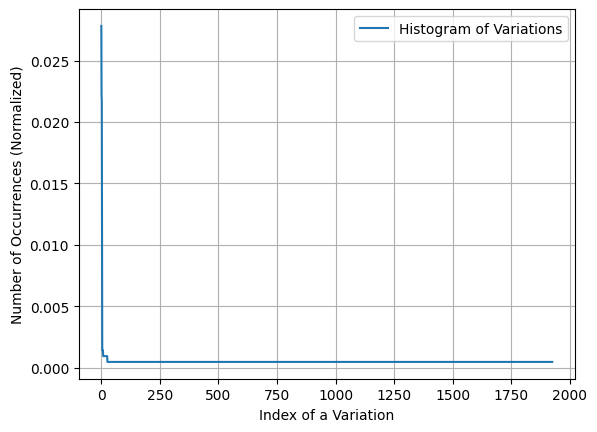

In [8]:
s = sum(unique_variations.values)
h = unique_variations.values/s
plt.plot(h, label="Histogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurrences (Normalized)')
plt.legend()
plt.grid()
plt.show()

* Most variation are not repetative and occures very less frequently

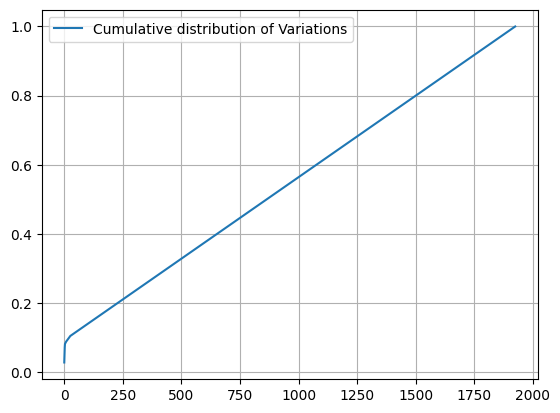

In [9]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()


Q.3. How to featurize the Variation feature? </br>
--> As Variation has 1926 unique categories, it is not a good idea to do one hot encoding. So Response coding

In [10]:
# RESPONSE CODING
variation_class_dict = defaultdict(list)

for variation, cls in zip(train_df["Variation"], train_df["Class"]):
    variation_class_dict[variation].append(cls)

sum(len(v) for v in variation_class_dict.values()) == len(train_df)

True

In [11]:
NUM_CLASSES = 9
alpha = 1  # Laplace smoothing

variation_response_dict = {}

for variation, class_list in variation_class_dict.items():
    counts = np.zeros(NUM_CLASSES)

    for cls in class_list:
        counts[cls - 1] += 1   # class labels 1–9 → index 0–8

    # Laplace smoothing + normalization
    probs = (counts + alpha*10) / (counts.sum() + alpha * 90)

    variation_response_dict[variation] = probs

In [13]:
global_class_probs = (
    train_df["Class"]
    .value_counts(normalize=True)
    .sort_index()
    .values
)

def response_encode_variation(series, response_dict, fallback):
    return np.vstack([
        response_dict.get(variation, fallback)
        for variation in series
    ])

X_train_variation_rc = response_encode_variation(
    train_df["Variation"], variation_response_dict, global_class_probs
)

X_test_variation_rc = response_encode_variation(
    test_df["Variation"], variation_response_dict, global_class_probs
)

X_cv_variation_rc = response_encode_variation(
    cv_df["Variation"], variation_response_dict, global_class_probs
)


Q.4. How good is the variation feature in predicting yi(Class label)? <br>
--> We can find this by building a model predicting yi using variation feature only.

For values of alpha =  1e-06 The log loss is: 14.050825844375037
For values of alpha =  1e-05 The log loss is: 10.443752782762804
For values of alpha =  0.0001 The log loss is: 7.742147118671186
For values of alpha =  0.001 The log loss is: 7.351916406240364
For values of alpha =  0.01 The log loss is: 6.078962968719428
For values of alpha =  0.1 The log loss is: 5.953355601123104
For values of alpha =  1 The log loss is: 5.5986790135961195


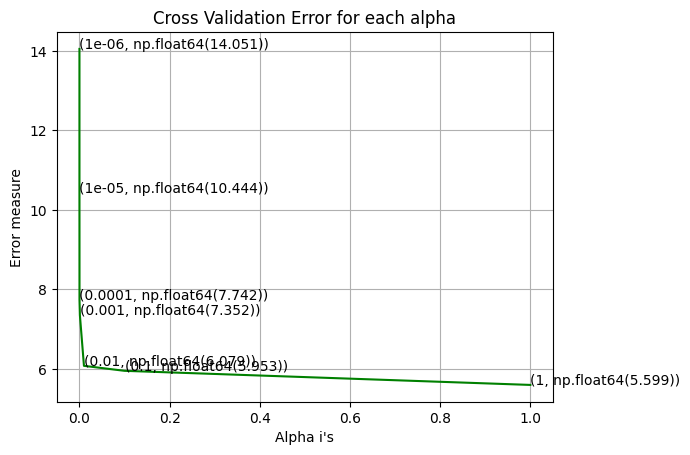

For values of best alpha =  1 The train log loss is: 0.8372765162676351
For values of best alpha =  1 The cross validation log loss is: 5.5986790135961195
For values of best alpha =  1 The test log loss is: 5.725559517655004


In [14]:
y_train = get_train_target()
y_test = get_test_target()
y_cv = get_cv_target()

cv_log_error_array=[]

# selection of hyperparameter alpha
# creation of alpha and their corresponding  logloss
alpha_list = [10 ** x for x in range(-6, 1)] # hyperparam for SGD classifier
for index, alpha in enumerate(alpha_list):
    # define the model as logistic regression
    clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
    # define the calibration model
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")

    # # training the model(redundant)
    # clf.fit(train_gene_ohe, y_train)

    # training the calibration model
    sig_clf.fit(X_train_variation_rc, y_train)
    
    # after traning, predict the probability for cv data with the calibration model
    predict_y = sig_clf.predict_proba(X_cv_variation_rc)

    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=sig_clf.classes_))
    print('For values of alpha = ', alpha, "The log loss is:", cv_log_error_array[index])

fig, ax = plt.subplots()
ax.plot(alpha_list, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha_list[i],np.round(txt,3)), (alpha_list[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# the best alpha
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha_list[best_alpha], penalty='l2', loss='log_loss', random_state=42)

# redundant
# clf.fit(train_gene_ohe, y_train)

# define calibration model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_variation_rc, y_train)

predict_y = sig_clf.predict_proba(X_train_variation_rc)
print('For values of best alpha = ', alpha_list[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_cv_variation_rc)
print('For values of best alpha = ', alpha_list[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test_variation_rc)
print('For values of best alpha = ', alpha_list[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=sig_clf.classes_))
